# Author: Alejandro C. Parra Garcia

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

Original data from Kaggle: https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data?select=DailyDelhiClimateTrain.csv

In [2]:
url="https://github.com/The-Katz-School-at-Yeshiva-University/Auto.Mach.Learn/blob/main/M8%20Practical%20Challenge%20Time-Series%20Prediction%E2%80%94Python%20versus%20DataRobot/Data%20Set/DailyDelhiClimateTrain.csv?raw=true"

In [3]:
df = pd.read_csv(url, parse_dates=['date'], index_col='date')
df=df.drop(columns=['humidity', 'wind_speed','meanpressure'])
df.drop(df.tail(1).index,inplace=True) 
df

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000
...,...
2016-12-27,16.850000
2016-12-28,17.217391
2016-12-29,15.238095


In [4]:
df.isnull().sum()

meantemp    0
dtype: int64

In [5]:
df.dtypes

meantemp    float64
dtype: object

In [7]:
# We save the data Set for DataRobot
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html

compression_opts = dict(method='zip',
                        archive_name='DailyDelhiClimate.csv')  
df.to_csv('out.zip',sep=';', index=True,
          compression=compression_opts) 

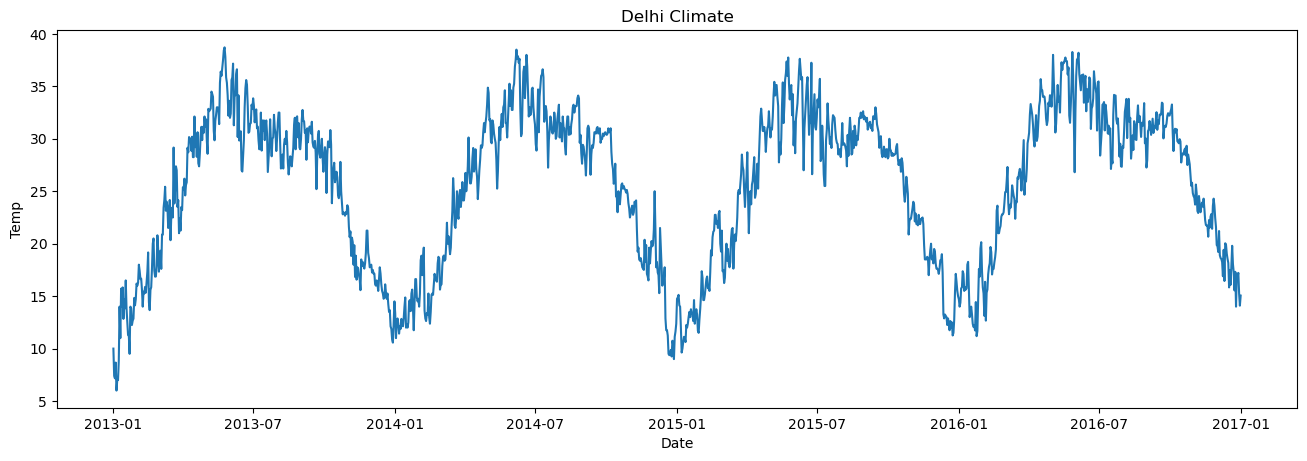

In [6]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df.meantemp)
plt.title('Delhi Climate')
plt.ylabel('Temp')
plt.xlabel('Date')
plt.show()

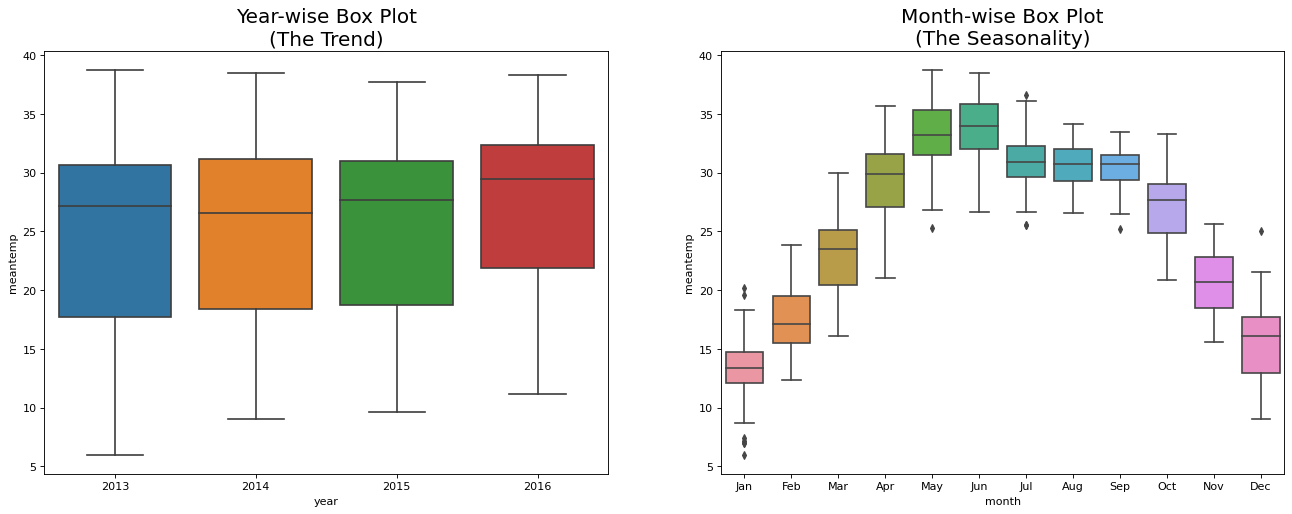

In [7]:
# Code from https://www.machinelearningplus.com/time-series/time-series-analysis-python/

# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='meantemp', data=df, ax=axes[0])
sns.boxplot(x='month', y='meantemp', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

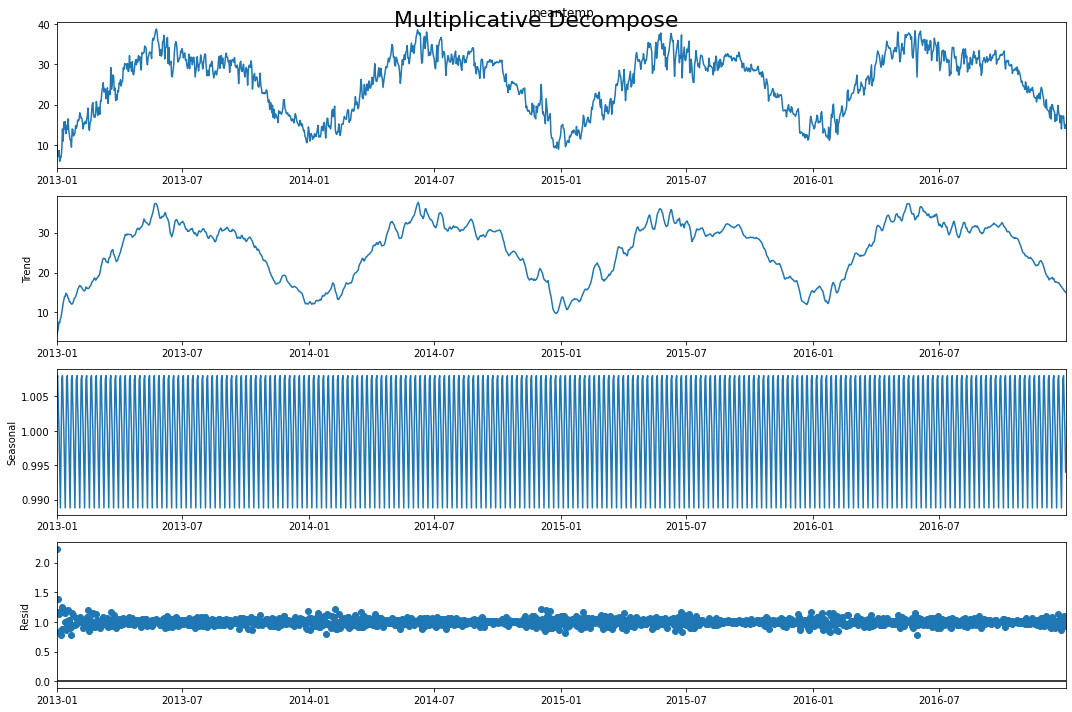

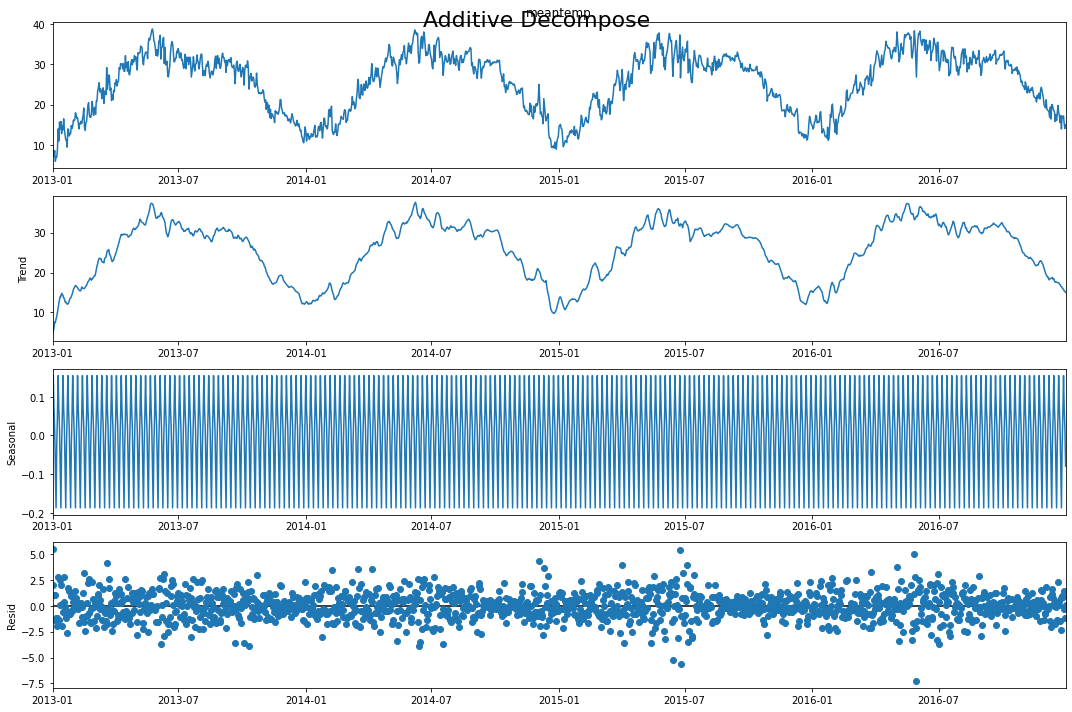

In [8]:

# Code from https://www.machinelearningplus.com/time-series/time-series-analysis-python/
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['meantemp'], model='multiplicative', extrapolate_trend='freq')
# Additive Decomposition
result_add = seasonal_decompose(df['meantemp'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (15,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

### Deseasonalized

[]

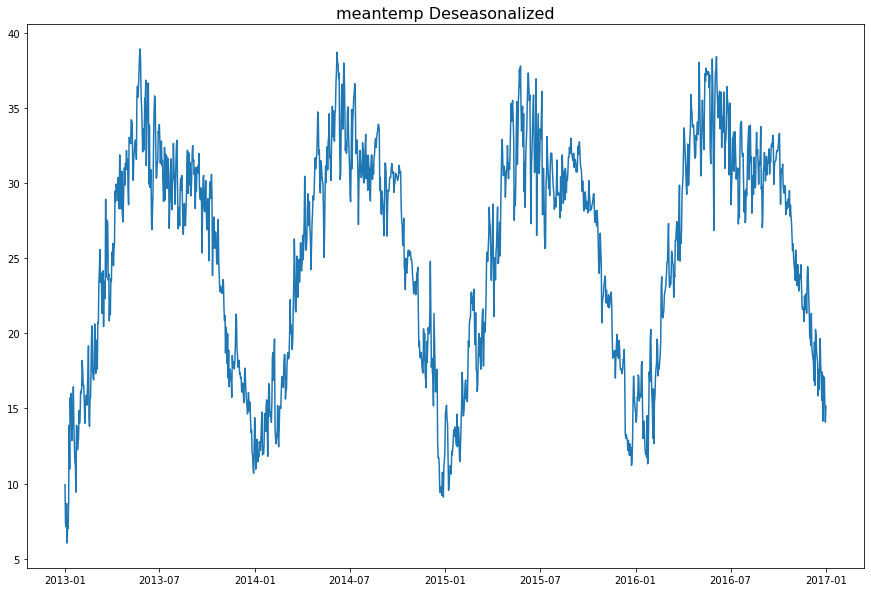

In [9]:
# Subtracting the Trend Component.
# Time Series Decomposition
result_mul = seasonal_decompose(df['meantemp'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df.meantemp.values / result_mul.seasonal
df['meantemp_deseasonalized']=deseasonalized

# Plot
plt.plot(deseasonalized)
plt.title('meantemp Deseasonalized', fontsize=16)
plt.plot()

# MODELS

# ARIMA

In [10]:
from statsmodels.tsa.arima.model import ARIMA

In [11]:
df_arima=df["meantemp_deseasonalized"]

                                  SARIMAX Results                                  
Dep. Variable:     meantemp_deseasonalized   No. Observations:                 1461
Model:                      ARIMA(5, 1, 0)   Log Likelihood               -2764.825
Date:                     Sun, 07 Nov 2021   AIC                           5541.651
Time:                             19:11:27   BIC                           5573.368
Sample:                         01-01-2013   HQIC                          5553.482
                              - 12-31-2016                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2102      0.021     -9.840      0.000      -0.252      -0.168
ar.L2         -0.1559      0.024     -6.540      0.000      -0.203      -0.109
ar.L3       

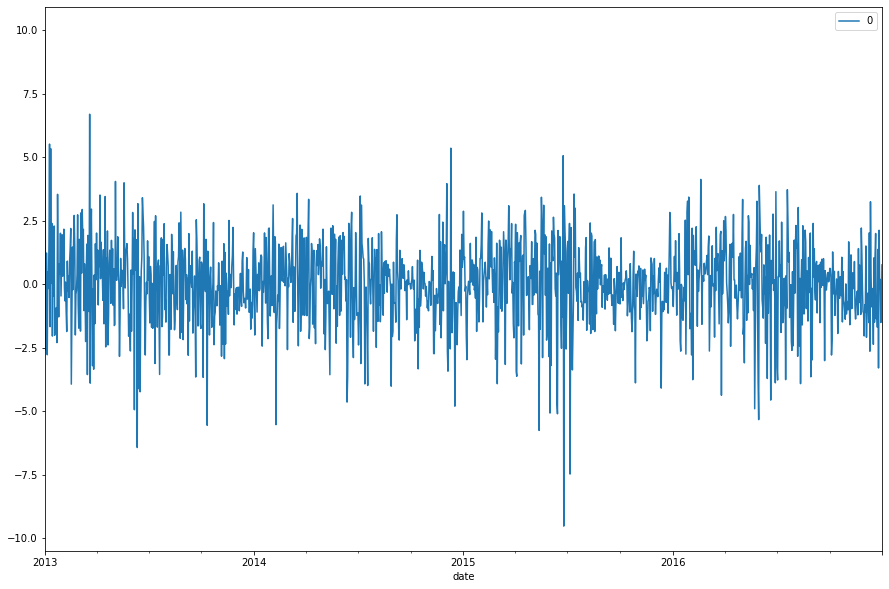

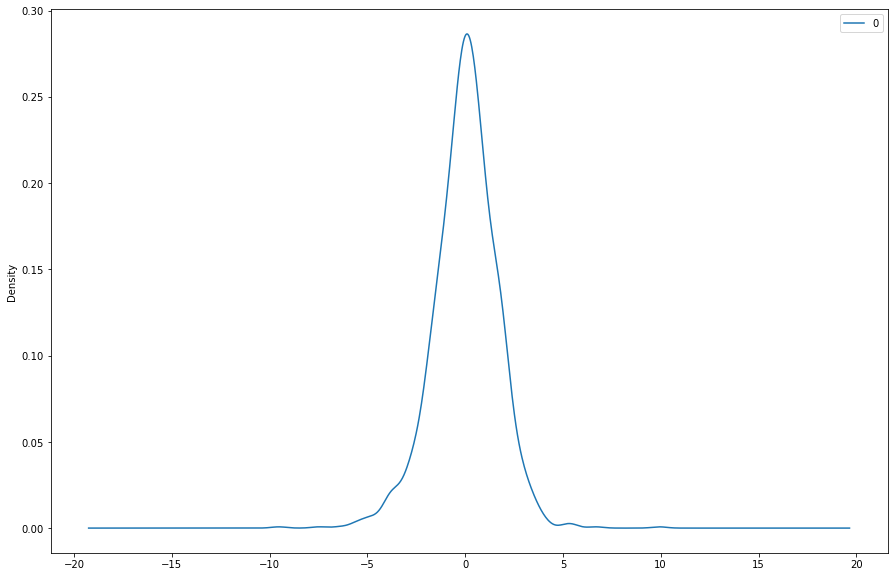

                 0
count  1461.000000
mean      0.013468
std       1.628493
min      -9.525113
25%      -0.897903
50%       0.076313
75%       1.003279
max       9.926311


In [12]:
model = ARIMA(df_arima, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [13]:
# Split train and Test, Test is the last year, from 1-Jan-2016 to 12-dic-2016
# split into train and test sets
X = df_arima.values
#size = int(len(X) * 0.7)
size=1095
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [14]:
# code base on: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

Test RMSE:  1.5885418984004303


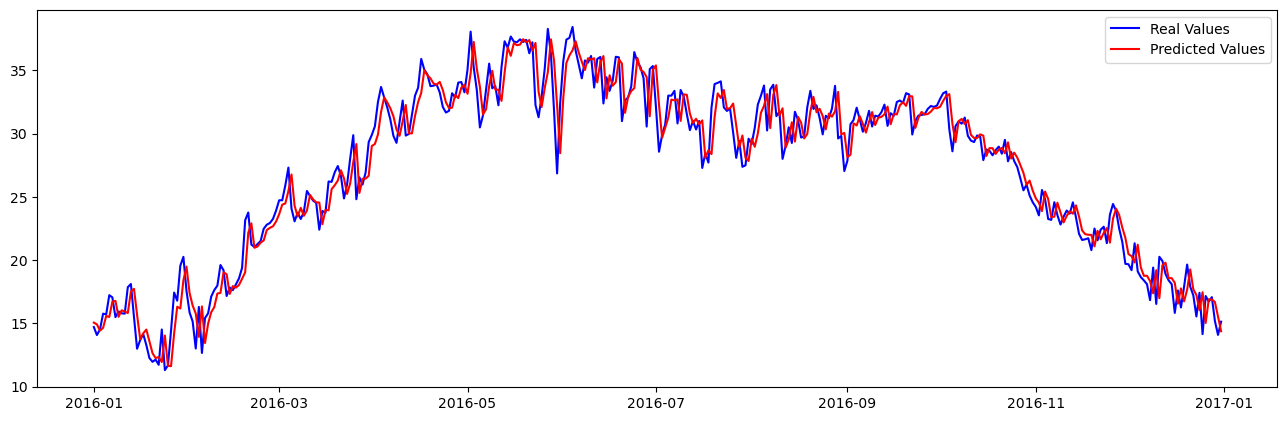

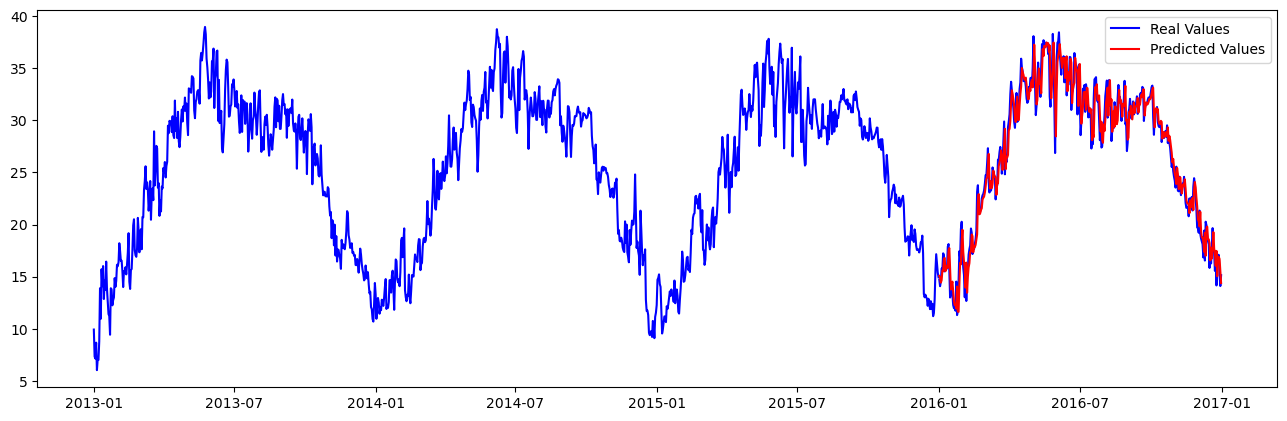

In [15]:
# evaluate forecasts
size=1095
train_p, test_p = df_arima[0:size], df_arima[size:len(X)]
df_copy=df[size:len(X)].copy()
df_copy["Predictions_ARIMA"]=predictions

rmse_ARIMA = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: ', str(rmse_ARIMA))
# plot forecasts against actual outcomes
plt.figure(figsize=(16,5), dpi=100)
plt.plot(test_p, c='b', label="Real Values")
plt.plot(df_copy["Predictions_ARIMA"], color='red',label="Predicted Values")
plt.legend()
plt.show()


# plot forecasts against actual outcomes
plt.figure(figsize=(16,5), dpi=100)
plt.plot(train_p, c='b', label="Real Values")
plt.plot(test_p, c='b')
plt.plot(df_copy["Predictions_ARIMA"], color='red',label="Predicted Values")
plt.legend()
plt.show()

# Autoregression 

In [16]:
from statsmodels.tsa.ar_model import AutoReg

In [17]:
df_AR=df["meantemp_deseasonalized"]

In [18]:
# Split train and Test, Test is the last year, from 1-Jan-2016 to 12-dic-2016
X = df_AR.values
#size = int(len(X) * 0.7)
size=1095
train, test = X[0:size], X[size:len(X)]

In [19]:
model = AutoReg(train, lags=1)
model_fit = model.fit()
# make prediction
predictions = model_fit.predict(start=size, end=len(X)-1)

Test RMSE:  6.5555040314708455


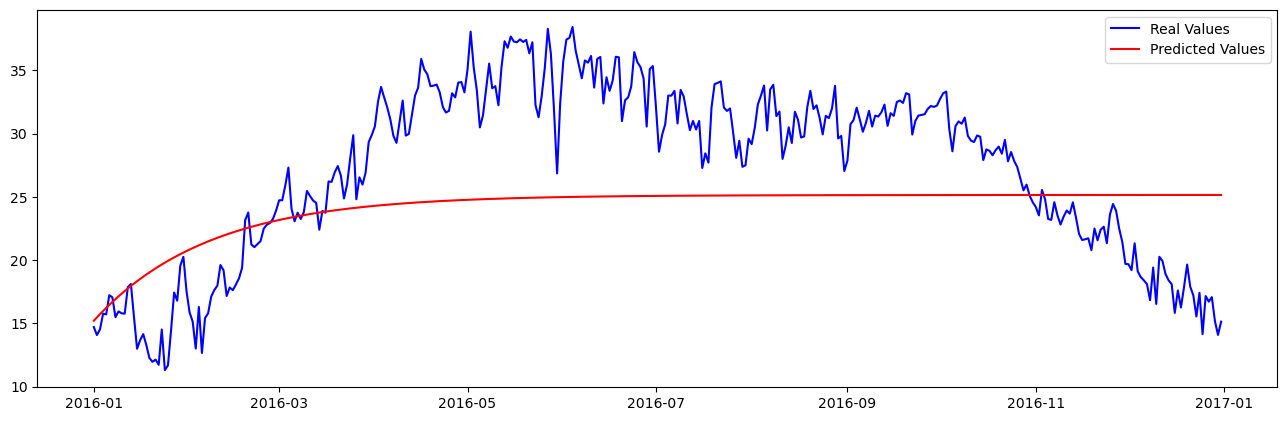

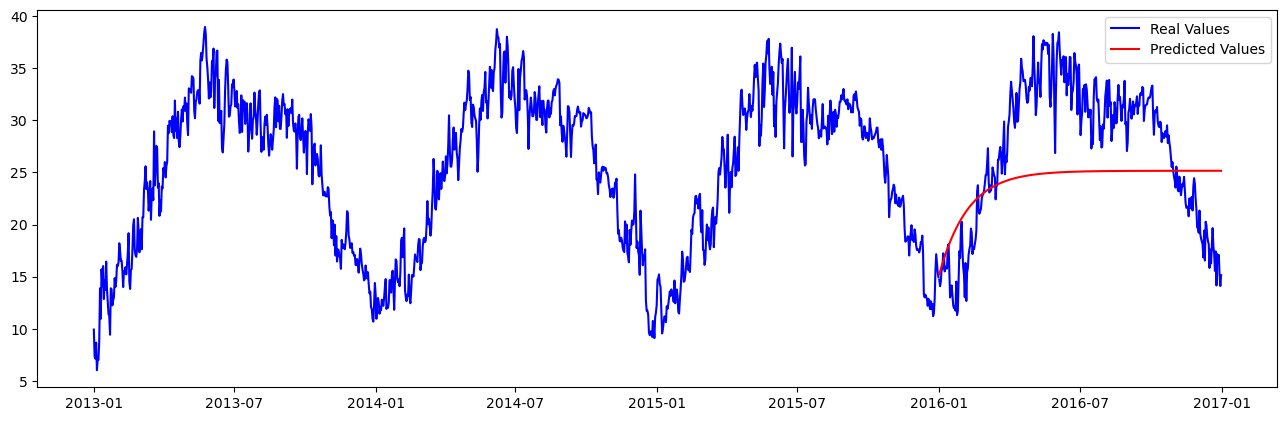

In [20]:
# evaluate forecasts
size=1095
train_p, test_p = df_AR[0:size], df_AR[size:len(X)]
#df_copy=df[size:len(X)].copy()
df_copy["Predictions_Autoregression"]=predictions

rmse_Autoregression = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: ', str(rmse_Autoregression))
# plot forecasts against actual outcomes
plt.figure(figsize=(16,5), dpi=100)
plt.plot(test_p, c='b', label="Real Values")
plt.plot(df_copy["Predictions_Autoregression"], color='red',label="Predicted Values")
plt.legend()
plt.show()


# plot forecasts against actual outcomes
plt.figure(figsize=(16,5), dpi=100)
plt.plot(train_p, c='b', label="Real Values")
plt.plot(test_p, c='b')
plt.plot(df_copy["Predictions_Autoregression"], color='red',label="Predicted Values")
plt.legend()
plt.show()

# Autoregressive Moving Average (ARMA)

In [21]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
df_ARMA=df["meantemp_deseasonalized"]

In [23]:
# Split train and Test, Test is the last year, from 1-Jan-2016 to 12-dic-2016
X = df_ARMA.values
#size = int(len(X) * 0.7)
size=1095
train, test = X[0:size], X[size:len(X)]

In [24]:
model = ARIMA(train, order=(2, 0, 1))
model_fit = model.fit()
# make prediction
predictions = model_fit.predict(start=size, end=len(X)-1)

Test RMSE:  11.261958580452083


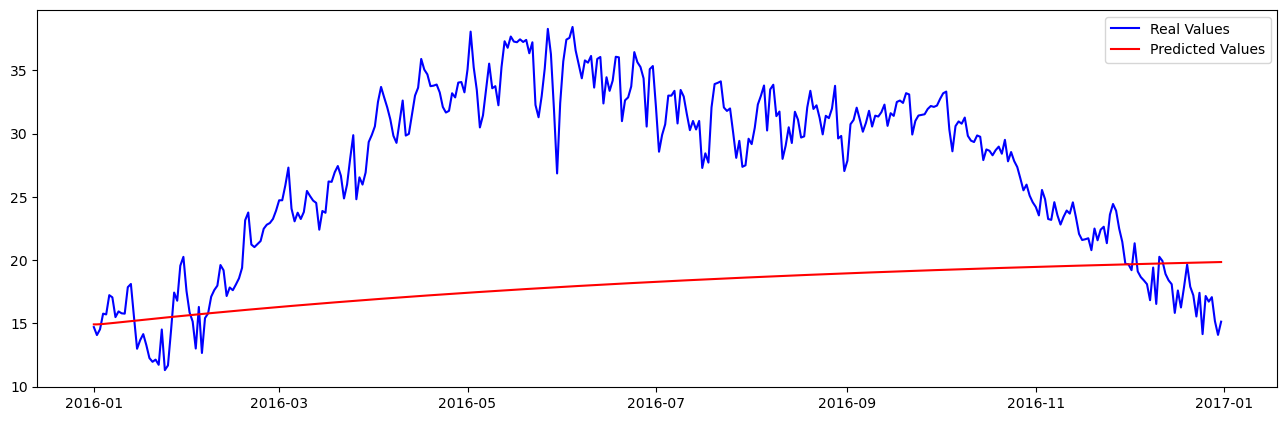

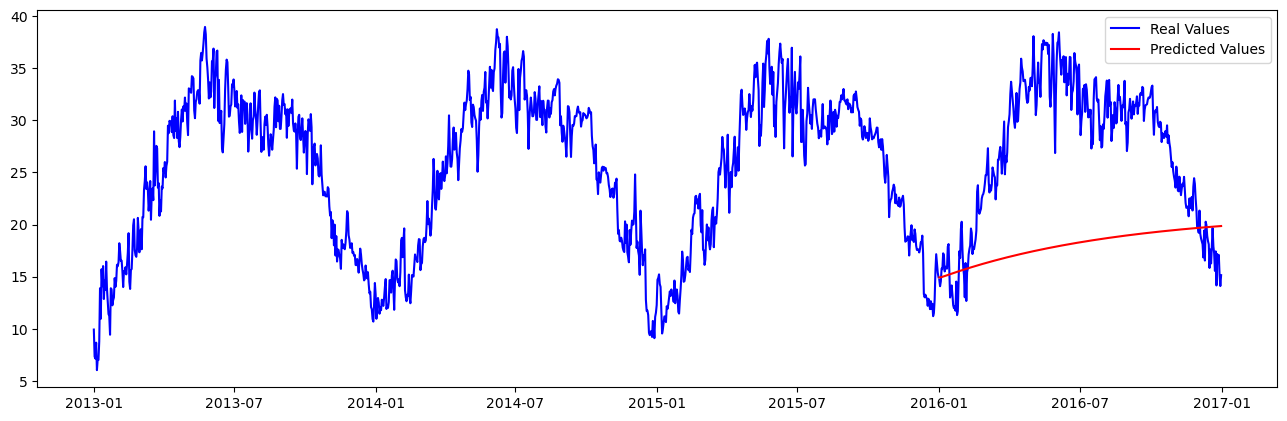

In [25]:
# evaluate forecasts
size=1095
train_p, test_p = df_AR[0:size], df_AR[size:len(X)]
#df_copy=df[size:len(X)].copy()
df_copy["Predictions_ARMA"]=predictions

rmse_ARMA = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: ', str(rmse_ARMA))
# plot forecasts against actual outcomes
plt.figure(figsize=(16,5), dpi=100)
plt.plot(test_p, c='b', label="Real Values")
plt.plot(df_copy["Predictions_ARMA"], color='red',label="Predicted Values")
plt.legend()
plt.show()


# plot forecasts against actual outcomes
plt.figure(figsize=(16,5), dpi=100)
plt.plot(train_p, c='b', label="Real Values")
plt.plot(test_p, c='b')
plt.plot(df_copy["Predictions_ARMA"], color='red',label="Predicted Values")
plt.legend()
plt.show()

# Compare the models

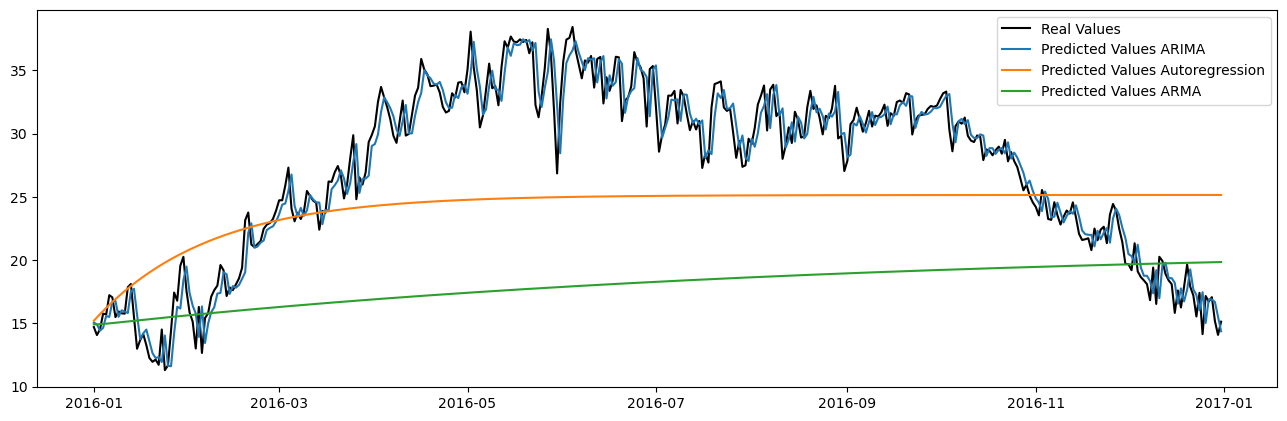

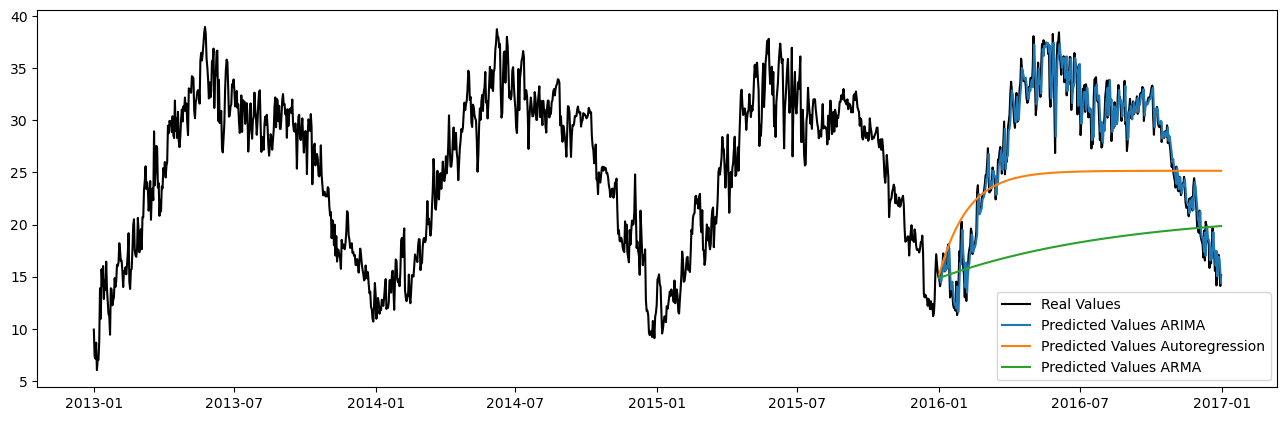

In [26]:
# plot forecasts against actual outcomes
plt.figure(figsize=(16,5), dpi=100)
plt.plot(test_p, c='black', label="Real Values")
plt.plot(df_copy["Predictions_ARIMA"],label="Predicted Values ARIMA")
plt.plot(df_copy["Predictions_Autoregression"],label="Predicted Values Autoregression")
plt.plot(df_copy["Predictions_ARMA"],label="Predicted Values ARMA")
plt.legend()
plt.show()


# plot forecasts against actual outcomes
plt.figure(figsize=(16,5), dpi=100)
plt.plot(train_p, c='black', label="Real Values")
plt.plot(test_p, c='black')
plt.plot(df_copy["Predictions_ARIMA"],label="Predicted Values ARIMA")
plt.plot(df_copy["Predictions_Autoregression"],label="Predicted Values Autoregression")
plt.plot(df_copy["Predictions_ARMA"],label="Predicted Values ARMA")
plt.legend()
plt.show()

In [27]:
print('Test ARIMA RMSE:\t\t', str(rmse_ARIMA))
print('Test Autoregression RMSE:\t', str(rmse_Autoregression))
print('Test ARMA RMSE:\t\t\t', str(rmse_ARMA))

Test ARIMA RMSE:		 1.5885418984004303
Test Autoregression RMSE:	 6.5555040314708455
Test ARMA RMSE:			 11.261958580452083


# Conclusion

We can see from the RMSE and from the graph, that the ARIMA model achieve the highest performance. And that the other two model are way worse, being the Autoregression the second one with an RMSE of 6.5, and the ARMA with a 11.2
